In [1]:
%matplotlib inline
#parameters for visualization
opts={'size':5, 'node_border':False, 'node_size':100, 'font_size':9, 'vertex_alpha':0.9, 
      'vertex_label':None, 'edge_label':None,'vertex_color':'level', 'colormap':'seismic','verbose':True}

from eden.util.display import draw_graph, serialize_graph
from eden.modifier.graph import vertex_attributes 
import itertools
def plot(graphs, file_name=None, opts=None):    
    graphs = vertex_attributes.colorize(graphs, output_attribute = 'level', labels = ['A','U','C','G'])
    for i,graph in enumerate(graphs): 
        if file_name is not None:
            draw_graph(graph, file_name=file_name+str(i)+'.png', **opts)
        else:
            draw_graph(graph, **opts)

def pre_process_rnashapes( iterable ):
    from eden.converter.rna.rnashapes import rnashapes_to_eden
    graphs = rnashapes_to_eden( iterable, shape_type=5, energy_range=35, max_num=4, split_components=True )
    return graphs

def pre_process_structure( iterable ):
    from eden.converter.rna.rnashapes_struct import rnashapes_struct_to_eden
    graphs = rnashapes_struct_to_eden(iterable, energy=False, shape=True, dotbracket=False, shape_type=5, energy_range=35, max_num=4, split_components=True)
    return graphs

def pre_process_contraction( iterable ):
    from eden.converter.rna.rnashapes import rnashapes_to_eden
    graphs = rnashapes_to_eden( iterable, shape_type=5, energy_range=35, max_num=4, split_components=True )
    
    #annotate in node attribute 'type' the incident edges' labels
    from eden.modifier.graph import vertex_attributes
    graphs = vertex_attributes.incident_edge_label(graphs, level=1, output_attribute='type', separator='.')
    
    from eden.modifier.graph.structure import contraction, contraction_modifier
    label_modifier = contraction_modifier(attribute_in='type', attribute_out='label', reduction='set_categorical')
    
    #reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
    weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='sum')
    modifiers = [label_modifier, weight_modifier]
    
    #contract the graph on the 'type' attribute
    graphs = contraction(graphs, contraction_attribute='type', modifiers=modifiers)
    
    return graphs

import itertools
def join_pre_processes( data, pre_processes, weights):
    if hasattr( data, '__iter__' ):
        iterable = data
    else: #if not then process url or file with fasta_to_fasta
        from eden.modifier.fasta import fasta_to_sequence
        iterable = fasta_to_sequence( data )
    from eden import util
    return util.join_pre_processes(iterable, pre_processes=pre_processes, weights=weights)

def pre_process( data ):
    weights = [0.2, 0.4, 0.4]
    pre_processes = [pre_process_rnashapes, pre_process_structure, pre_process_contraction]
    return join_pre_processes( data, pre_processes, weights)


def rfam_to_matrix(rfam_id, n_max=50):
    def rfam_uri(family_id):
        return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

    from eden.converter.fasta import fasta_to_sequence
    seqs = fasta_to_sequence(rfam_uri(rfam_id))

    from itertools import islice,tee
    seqs = islice(seqs,n_max)
    seqs,seqs_=tee(seqs)
    
    #for image
    graphs = pre_process_rnashapes(seqs_)
    plot(graphs, file_name='rna_img', opts=opts)
    
    #for similarity
    from eden.graph import ListVectorizer
    vectorizer = ListVectorizer( complexity=4 )
    graphs_list, weights = pre_process( seqs )
    X = vectorizer.transform( graphs_list, weights=weights )
    return X

def rfam_data(rfam_ids, n_max=50):
    import numpy as np
    from scipy.sparse import vstack
    for i,rfam_id in enumerate(rfam_ids):
        X_=rfam_to_matrix(rfam_id, n_max=n_max)
        y_ = [i] * X_.shape[0]
        if i==0:
            X=X_
            y=y_
        else:
            X = vstack([X, X_], format="csr")
            y=y+y_
    y = np.array(y)
    return X,y

In [2]:
def plot_embedding(X=None, y=None, labels=None, image_file_name=None, title=None, grid_size=5, cmap='gnuplot', density=False, x_min=None,y_min=None,x_max=None,y_max=None):
    import matplotlib.pyplot as plt
    from matplotlib import offsetbox
    from PIL import Image
    import numpy as np
    import math

    
    x_grid_cell_size=(x_max-x_min)/grid_size
    y_grid_cell_size=(y_max-y_min)/grid_size
    grid_cell_diagonal=math.sqrt(x_grid_cell_size*x_grid_cell_size+y_grid_cell_size*y_grid_cell_size)
    xval = np.linspace(x_min,x_max,grid_size)
    yval = np.linspace(y_min,y_max,grid_size)

    if image_file_name is not None:
        M=[]
        for xx in xval:
            for yy in yval:
                M.append([xx,yy])
        M = np.array(M)
        #for each grid point find closest points in Xemb
        selected_ids=[]
        from scipy.spatial import distance
        for v in M:
            selected_id = np.argsort([distance.euclidean(u,v) for u in X])[0]
            if distance.euclidean(X[selected_id],v) < grid_cell_diagonal:
                selected_ids.append(selected_id)
        
        ax = plt.subplot(111)
        for i in set(selected_ids):
            img = Image.open(image_file_name + str(i) + '.png')
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, zoom=1), X[i], pad=0, frameon=False)
            ax.add_artist(imagebox)
    if title is not None:
        plt.title(title)
    X_filtered=[]
    for v in X:
        x=v[0]
        y=v[1]
        if x >= x_min and x <= x_max and y >= y_min and y <= y_max:
            X_filtered.append(v)
    X=np.array(X_filtered)
    if len(X)>0:
        plt.scatter(X[:, 0], X[:, 1], cmap=cmap, alpha=.7, s=90, edgecolors='gray')
    
    plt.grid(True)
    plt.xticks(xval)
    plt.yticks(yval)
    if labels is not None:
        for id in range(X.shape[0]):
            label = str(labels[id])
            x = X[id, 0]
            y = X[id, 1]
            plt.annotate(label, xy=(x, y), xytext = (0, 0), textcoords = 'offset points')



In [3]:
%%time
rfam_ids=['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
          'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
          'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
          'RF01942','RF01998','RF02005','RF02012','RF02034']
id=1
X,y = rfam_data(rfam_ids[id:id+1],n_max=10)

CPU times: user 11.9 s, sys: 760 ms, total: 12.6 s
Wall time: 17.7 s


/Library/Python/2.7/site-packages/pygraphviz/agraph.py:1281: RuntimeWarning: Fontconfig warning: ignoring UTF-8: not a valid region tag

  warnings.warn("".join(errors),RuntimeWarning)


In [4]:
%%time
TYPE='KQST'
if TYPE=='MDS':
    from sklearn import decomposition
    Xemb = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
elif TYPE=='MDS':
    from sklearn import manifold
    Xemb = manifold.MDS(n_components=2, n_init=1, max_iter=100).fit_transform(X)
elif TYPE=='KQST':    
    from eden.util.display import KernelQuickShiftTreeEmbedding
    Xemb=KernelQuickShiftTreeEmbedding(X, knn=25, k_threshold=0.75, metric='rbf', gamma=1e-2)

CPU times: user 23.4 ms, sys: 8.31 ms, total: 31.8 ms
Wall time: 77.3 ms


In [5]:
def plot_embedding_fixed(x_min=None,y_min=None,x_max=None,y_max=None):
    size=50
    resolution=5
    plt.figure(figsize=(size, size))
    plot_embedding(X=Xemb, y=y, labels=None, image_file_name='rna_img', title=None, grid_size=resolution, 
                   cmap='gnuplot', density=False, x_min=x_min,y_min=y_min,x_max=x_max,y_max=y_max)

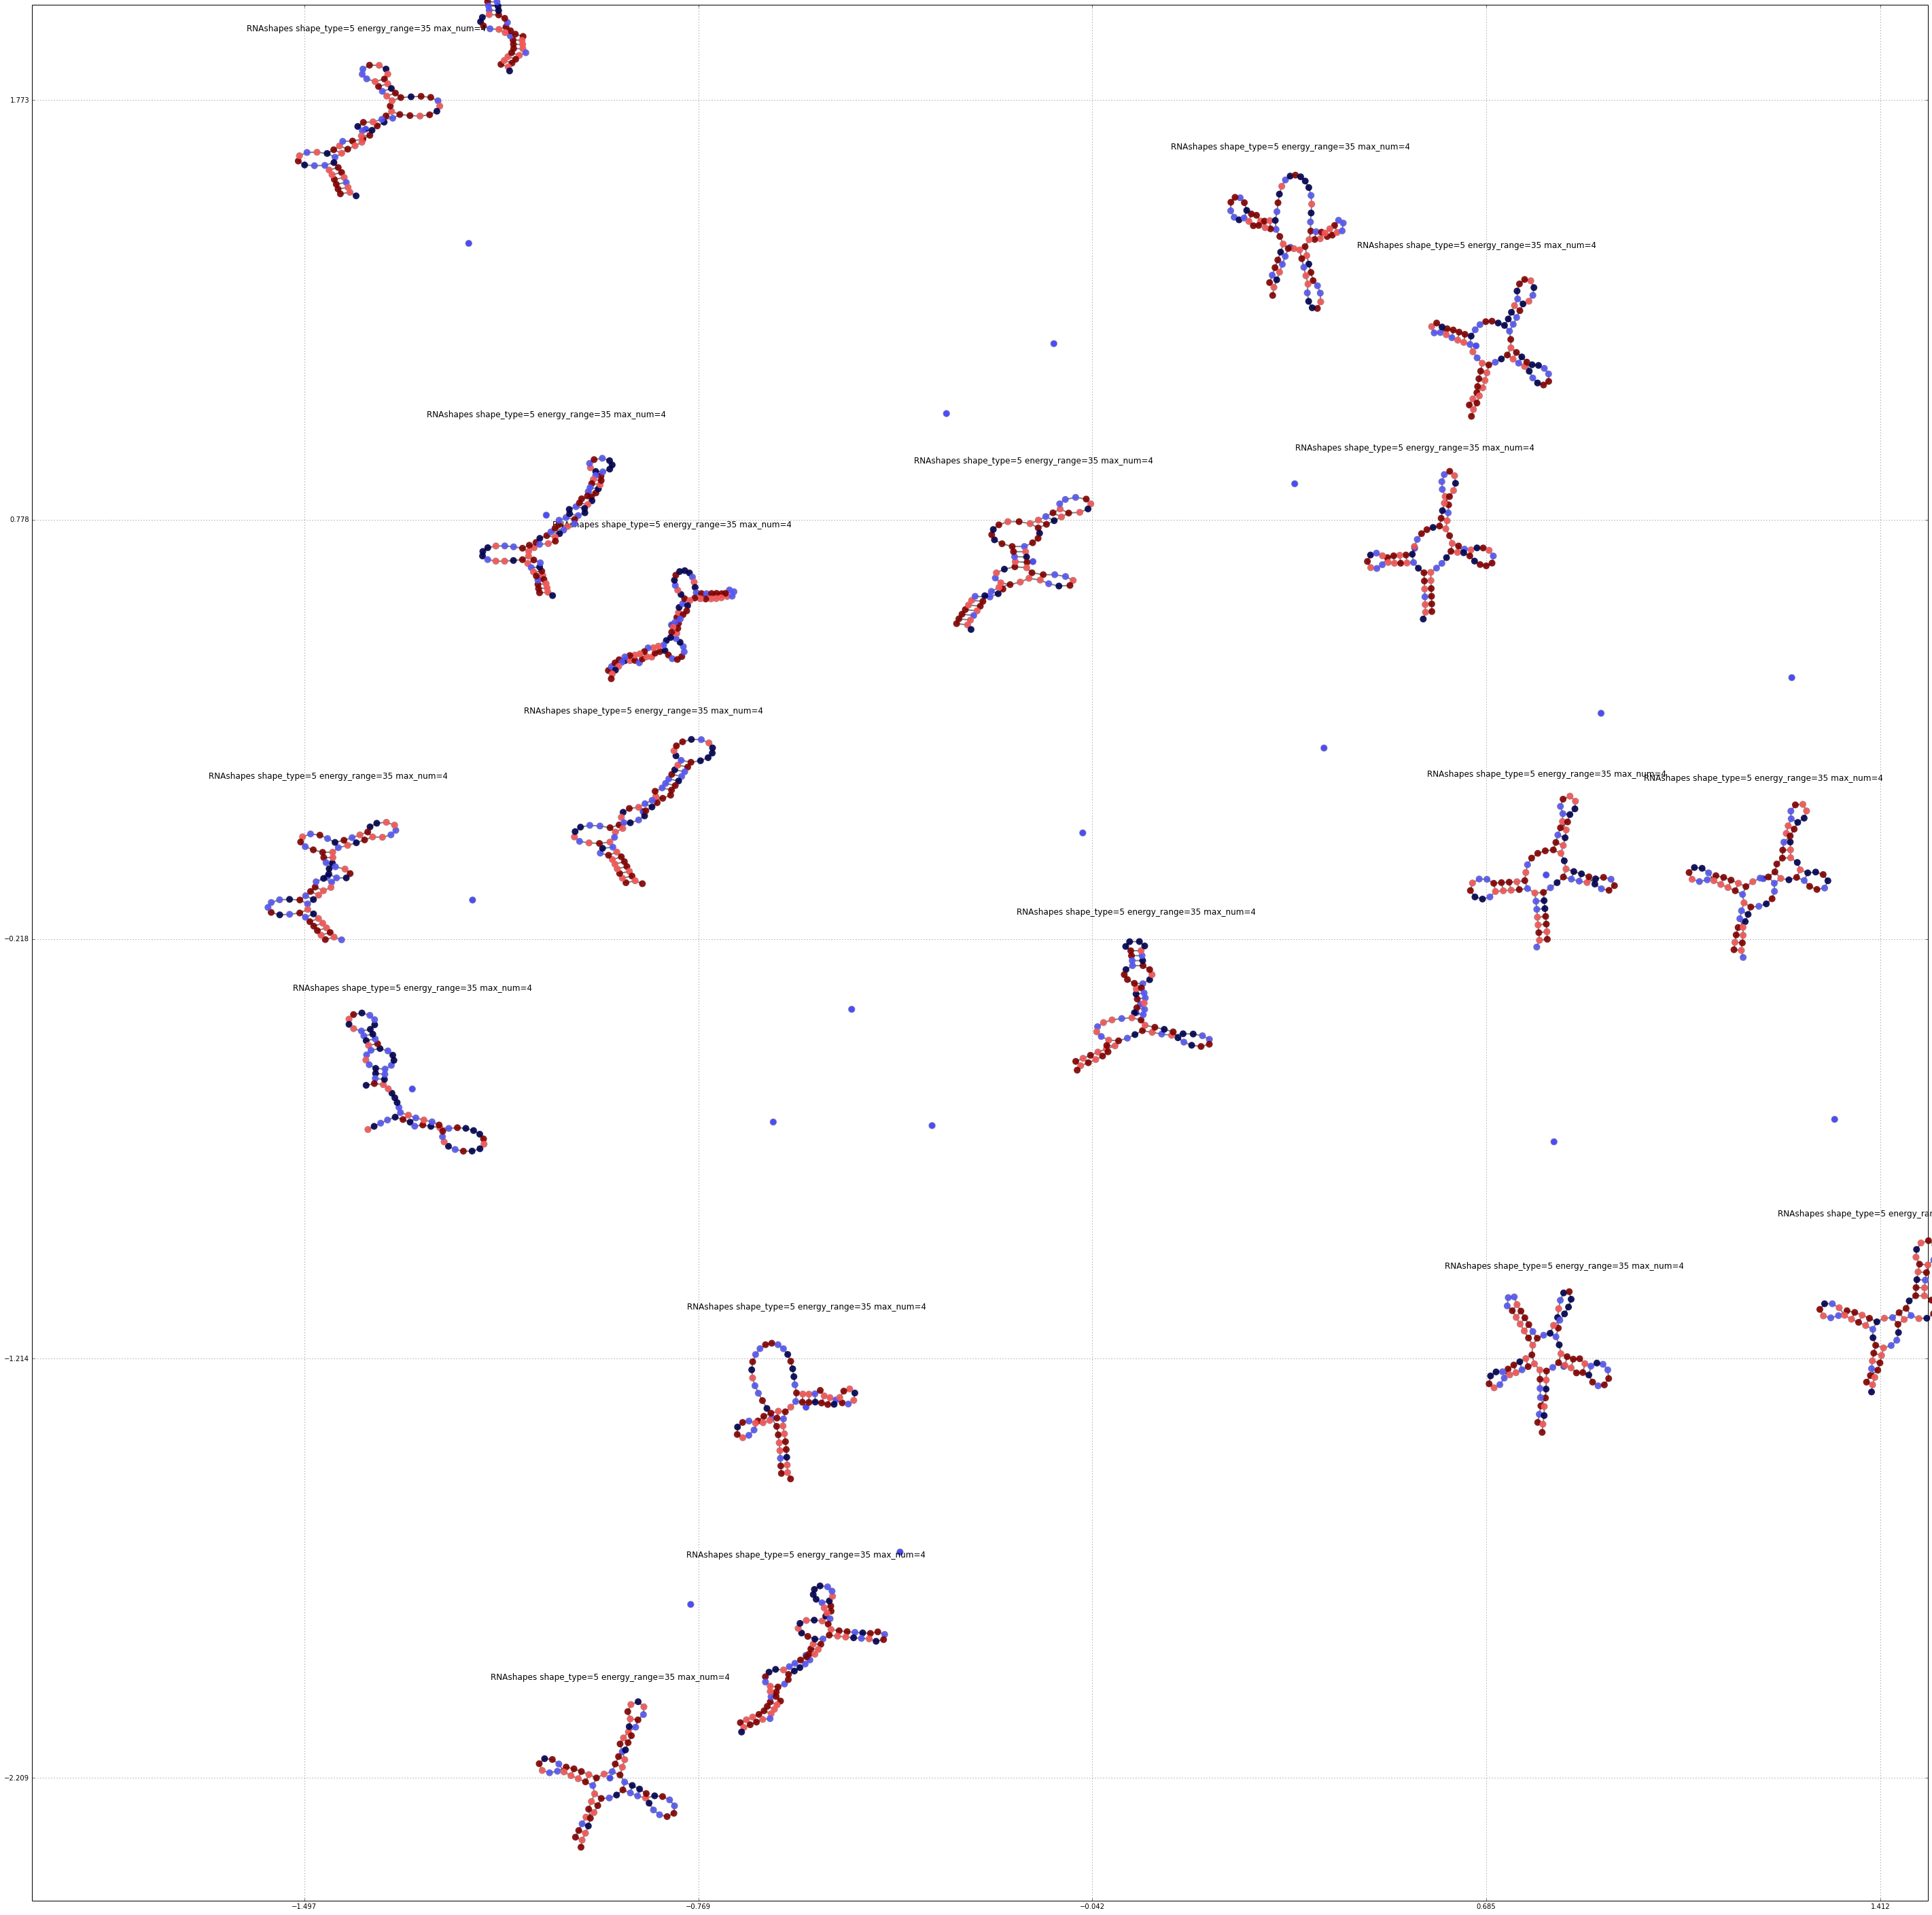

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html import widgets
from IPython.display import display

resolution=20
xx_min,yy_min= Xemb.min(axis=0)
xx_max,yy_max= Xemb.max(axis=0)
xx_step = float(xx_max-xx_min)/resolution
yy_step = float(yy_max-yy_min)/resolution

x_min_slider = widgets.FloatSliderWidget(min=xx_min, max=xx_max, step=xx_step)
x_max_slider = widgets.FloatSliderWidget(min=xx_min, max=xx_max, step=xx_step)
y_min_slider = widgets.FloatSliderWidget(min=yy_min, max=yy_max, step=yy_step)
y_max_slider = widgets.FloatSliderWidget(min=yy_min, max=yy_max, step=yy_step)
w=widgets.interactive(plot_embedding_fixed, x_min=x_min_slider, x_max=x_max_slider, y_min=y_min_slider, y_max=y_max_slider)
display(w)